In [1]:
from time import sleep

import gym
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

from reinforcement_learning.utils.agent import Agent
from reinforcement_learning.utils.dataset import Dataset
from reinforcement_learning.utils.learner import Learner
from reinforcement_learning.utils.policy import Policy


In [2]:
np.set_printoptions(precision=2)

In [8]:
environment = gym.make('CartPole-v0')

state = environment.reset()
done = False
while not done:
    action = environment.action_space.sample()
    state, reward, done, info = environment.step(action=action)
    environment.render()
    sleep(0.1)
environment.close()

Acciones aleatorias.

In [3]:
environment = gym.make('CartPole-v0')

cumulative_rewards = []
for episode in range(350):
    cumulative_reward = 0
    state = environment.reset()
    done = False
    while not done:
        action = environment.action_space.sample()
        state, reward, done, info = environment.step(action=action)
        cumulative_reward += reward
    cumulative_rewards.append(cumulative_reward)

pd.Series(cumulative_rewards).plot()

Metemos agente y policy. Primero con epsilon 0 y después 0.1 para agregar un poco de aleatoriedad.
Pero este agente no optimiza, no aprende.

In [5]:
policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)

state = environment.reset()
done = False
while not done:
    action = agent.select_action(state=state)
    state, reward, done, info = environment.step(action=action)

In [6]:
policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)

for episode in range(350):
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state=state, epsilon=0.1)
        state, reward, done, info = environment.step(action=action)

In [7]:
policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)

cumulative_rewards = []
for episode in range(350):
    cumulative_reward = 0
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state=state, epsilon=0.1)
        state, reward, done, info = environment.step(action=action)
        cumulative_reward += reward
    cumulative_rewards.append(cumulative_reward)

pd.Series(cumulative_rewards).plot()

Metemos un dataset. Es simplemente una cola first-in-first-out.

In [10]:
policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)
dataset = Dataset(max_length=10_000)

for episode in range(350):
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state=state, epsilon=0.1)
        next_state, reward, done, info = environment.step(action=action)
        dataset.push((state, action, reward, next_state, done))
        state = next_state

### Nuestro objetivo es modificar los pesos del modelo de la policy para mejorarla.###

- Llamamos $model(state)[0]=Q(state,0)$ y $model(state)[1]=Q(state,1)$.

Idealmente,

$Q(state,0)=$ máximo de los rewards acumulados empezando en $state$ y tomando primero acción 0

$Q(state,1)=$ máximo de los rewards acumulados empezando en $state$ y tomando primero acción 1.

- La ecuación de Bellman nos dice que

$ Q(state, a) = reward + max_{a'} Q(next\text{_}state, a') $ si el episodio no termina en $next\text{_}observation$

$ Q(state, a) = reward $ si el episodio termina en $next\text{_}observation$

o sea

$ Q(state, a) - reward - max_{a'} Q(next\text{_}state, a') = 0$ si el episodio no termina en $next\text{_}observation$

$ Q(state, a) - reward = 0$ si el episodio termina en $next\text{_}observation$

- entonces intentamos optimizar

$ (Q(state, a) - reward - max_{a'} Q(next\text{_}state, a'))^2$ si $done=False$

$ (Q(state, a) - reward)^2$ si $done=True$

Esto sería para una iteración (pero no lo vamos a usar porque vamos a usar *mini-batches* y tomar el promedio. Esto es solo ilustrativo).

In [11]:
state, action, reward, next_state, done = dataset.sample(1)[0]

# Convert types
state = torch.Tensor(state)
next_state = torch.Tensor(next_state)

# Compute loss
q = policy.model(state)[action]
next_values = policy.model(next_state)

if not done:
    loss = (q - reward - next_values.max()) ** 2
else:
    loss = (q - reward) ** 2


In [8]:
environment = gym.make('CartPole-v1')

policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)
dataset = Dataset(max_length=10_000)
learner = Learner(policy=policy, batch_size=16)

cumulative_rewards = []
for episode in range(350):
    cumulative_reward = 0
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state, 0.1)
        next_state, reward, done, info = environment.step(action=action)
        dataset.push((state, action, reward, next_state, done))
        state = next_state
        learner.update(dataset)
        cumulative_reward += reward
    cumulative_rewards.append(cumulative_reward)


<AxesSubplot:>

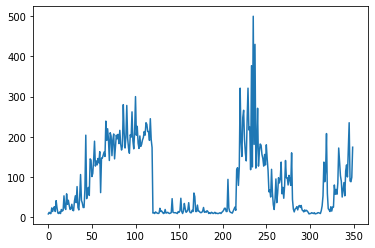

In [9]:
pd.Series(cumulative_rewards).plot()

## Train until winning 5 times in a row


In [10]:
import copy

In [11]:
environment = gym.make('CartPole-v1')

policy = Policy(state_dimension=4, num_actions=2)
agent = Agent(policy=policy)
dataset = Dataset(max_length=10_000)
learner = Learner(policy=policy, batch_size=16)
agents = []

cumulative_rewards = []
is_winner = False
for episode in tqdm(range(35000)):
    if is_winner:
        break
    cumulative_reward = 0
    # run episode
    state = environment.reset()
    done = False
    while not done:
        action = agent.select_action(state, epsilon=0.15)
        next_state, reward, done, info = environment.step(action=action)
        dataset.push((state, action, reward, next_state, done))
        state = next_state
        learner.update(dataset)
        cumulative_reward += reward
    cumulative_rewards.append(cumulative_reward)

    # evaluate agent
    if episode % 25 == 0:
        agents.append(copy.deepcopy(agent))
        for _ in range(5):
            total_reward = 0
            state = environment.reset()
            done = False
            while not done:
                action = agent.select_action(state)
                state, reward, done, info = environment.step(action=action)
                total_reward += reward
            if total_reward < 190:
                is_winner = False
                break
            is_winner = True

  0%|          | 0/35000 [00:00<?, ?it/s]

<AxesSubplot:>

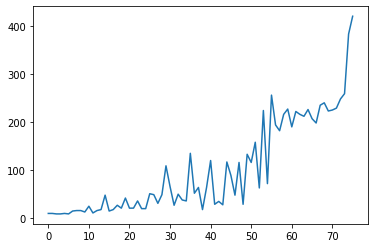

In [12]:
pd.Series(cumulative_rewards).plot()

In [17]:
from gym import wrappers

environment = gym.make('CartPole-v0')

for i, a in enumerate([agents[0]] + agents[-5:]):
    environment = wrappers.Monitor(environment, f'./videito_{i}', force=True)
    state = environment.reset()
    done = False
    while not done:
        action = a.select_action(state)
        state, reward, done, info = environment.step(action=action)
        environment.render()
        sleep(0.1)
    environment.close()

In [18]:
agents